# Phenotype classifcation using CellX 

This notebook shows how to take segmented time lapse microscopy images and use h2b fluorescence markers to classfiy mitotic state of the cell cycle. 

The sections of this notebook are as follows:

1. Load images
2. Localise the objects
3. Classify the objects
4. Batch process

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

This notebook uses the dask octopuslite image loader from the CellX/Lowe lab project.

In [1]:
from octopuslite import DaskOctopusLiteLoader
import btrack
from tqdm.auto import tqdm
import numpy as np
from scipy.special import softmax
import os
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from cellx import load_model
from cellx.tools.image import InfinitePaddedImage
from skimage.transform import resize
import glob
%matplotlib inline
plt.rcParams['figure.figsize'] = [18,8]

## 1. Load segmentation images

#### *Important:* from this point on you will need to be consistent with the use of cropping and alignment. 
Using a previously generated alignment transformation will aid greatly in the tracking notebook, which depends on the object localisation performed in this notebook. Cropping your images will ensure that no border effects from the translational shift are seen. 

In [7]:
# load images
expt = 'ND0012'
pos = 'Pos5'
root_dir = '/home/nathan/data/kraken/ras'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
transform_path = f'{root_dir}/{expt}/{pos}/gfp_transform_tensor.npy'
images = DaskOctopusLiteLoader(image_path, 
                               transforms=transform_path,
                               crop=(1200,1600), 
                               remove_background=False)

Using cropping: (1200, 1600)


## 2. Localise the objects
We need to also measure the mean intensity regionprops parameter in order to differentiate object class, for which we need to provide an image to measure. This means we need to provide the segmentation images twice: once to find the centroid and once to measure the pixel intensity. 

In [7]:
objects = btrack.utils.segmentation_to_objects(
    images['mask'], images['mask'],
    properties = ('area', 'max_intensity', ),
)

[INFO][2022/02/04 10:18:09 AM] Localizing objects from segmentation...
[INFO][2022/02/04 10:18:09 AM] Found intensity_image data
[INFO][2022/02/04 10:18:09 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 10:28:10 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 10:28:10 AM] ...Found 9566 objects in 1738 frames.


In [3]:
objects = btrack.utils.segmentation_to_objects(
    images['mask'], images['mask'],
    properties = ('area', 'max_intensity', ),
)

[INFO][2022/02/04 03:54:11 PM] Localizing objects from segmentation...
[INFO][2022/02/04 03:54:11 PM] Found intensity_image data
[INFO][2022/02/04 03:54:11 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 04:04:55 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 04:05:02 PM] ...Found 1018877 objects in 1738 frames.


# 5 objects per frame doesnt sound right

In [8]:
9566/1738

5.504027617951668

# is it image crop and transform?

In [10]:
import scipy.ndimage as nd

In [11]:
count_gfp, count_rfp = 0, 0
for i in images['mask']:
        count_gfp += nd.label(i == 1)[-1]
        count_rfp += nd.label(i == 2)[-1]

In [12]:
count_gfp, count_rfp

(749627, 33193)

# no it is not crop and transform

# testing on ten frames

In [13]:
count_gfp, count_rfp = 0, 0
for i in tqdm(images['mask'][0:10]):
        count_gfp += nd.label(i == 1)[-1]
        count_rfp += nd.label(i == 2)[-1]

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
count_gfp, count_rfp

(1020, 29)

# trying with just single image, no props

In [16]:
objects = btrack.utils.segmentation_to_objects(
    images['mask'][0:10],
    properties = ('area', ),
)

[INFO][2022/02/04 11:50:39 AM] Localizing objects from segmentation...
[INFO][2022/02/04 11:50:40 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 11:50:40 AM] ...Found 20 objects in 10 frames.


# trying with unique id in each image segment

In [41]:
unique_stack = []
for i in images['mask'][0:10]:
    unique = nd.label(images['mask'][0])[0]
    unique_stack.append(unique)
unique_stack = np.stack(unique_stack)

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


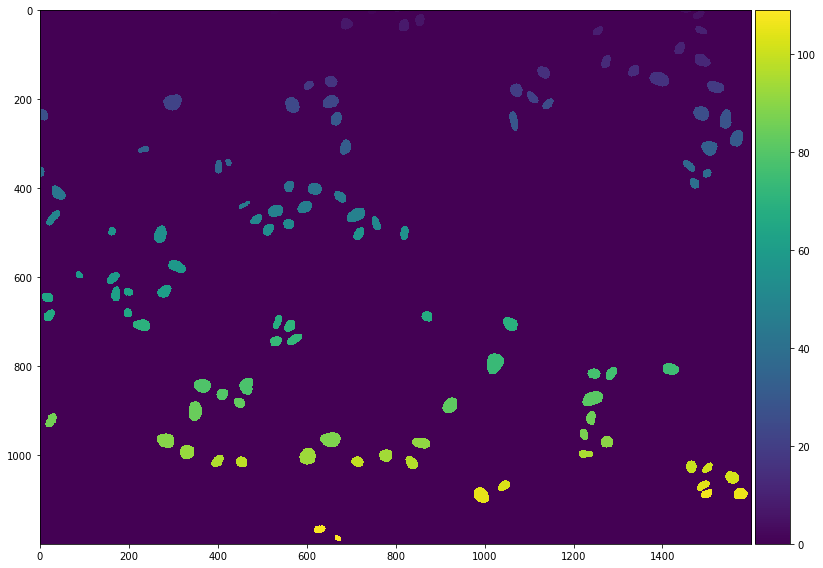

In [42]:
imshow(unique_stack[0])

In [43]:
objects = btrack.utils.segmentation_to_objects(
    unique_stack,
    properties = ('area', ),
)

[INFO][2022/02/04 12:02:22 PM] Localizing objects from segmentation...
[INFO][2022/02/04 12:02:22 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 12:02:22 PM] ...Found 1090 objects in 10 frames.


# seems like its either stack or uniqueness

In [44]:
stack = images['mask'][0:10].compute()

In [50]:
stack = stack.astype(int)

In [51]:
objects = btrack.utils.segmentation_to_objects(
    stack,
    properties = ('area', ),
)

[INFO][2022/02/04 12:05:07 PM] Localizing objects from segmentation...
[INFO][2022/02/04 12:05:07 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 12:05:07 PM] ...Found 20 objects in 10 frames.


# the issue is lack of ternary segmentation input in localisation

In [52]:
segmentation = images['mask'][0:10]

In [54]:
np.sum(segmentation).compute()

615494

In [55]:
def _is_binary(x: np.ndarray) -> bool:
        return ((x == 0) | (x == 1)).all()

In [57]:
_is_binary(segmentation.compute())

False

In [58]:
def _is_ternary(x: np.ndarray) -> bool:
        return ((x == 0) | (x == 1) | (x == 2)).all()

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


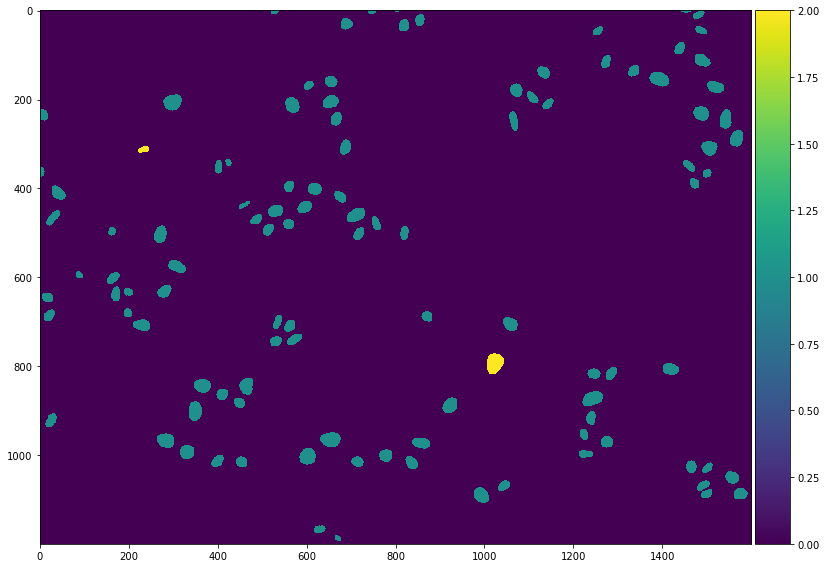

In [63]:
imshow(segmentation.compute()[0])

In [60]:
_is_ternary(segmentation.compute())

False

In [5]:
from skimage.measure import label, regionprops_table

In [8]:
image = images['mask'][0].compute().astype(int)

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


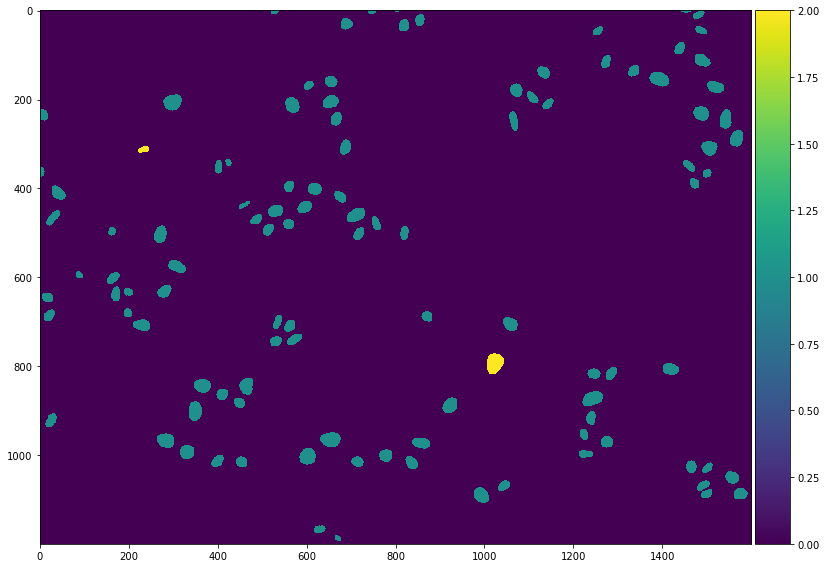

In [9]:
imshow(image)

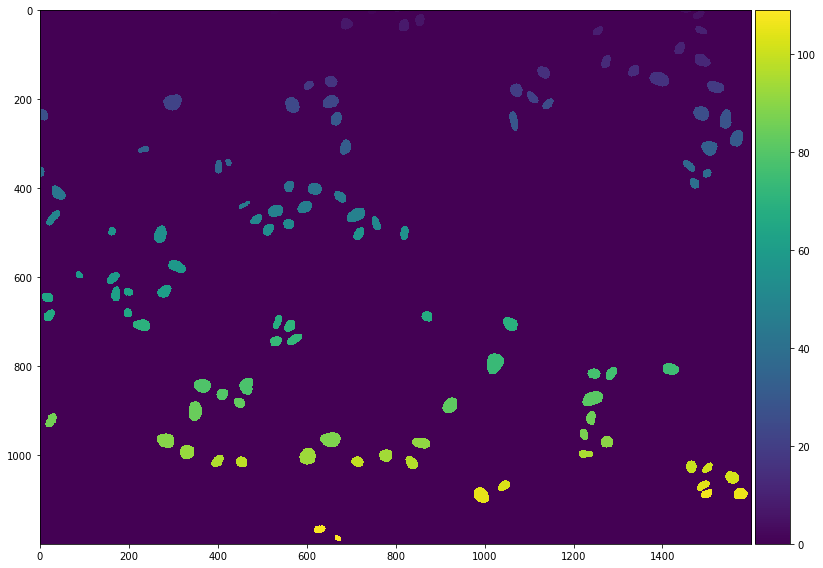

In [75]:
imshow(label(image))

In [73]:
_is_ternary(image)

True

In [76]:
_is_ternary(label(image))

False

In [77]:
_is_binary(label(image))

False

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


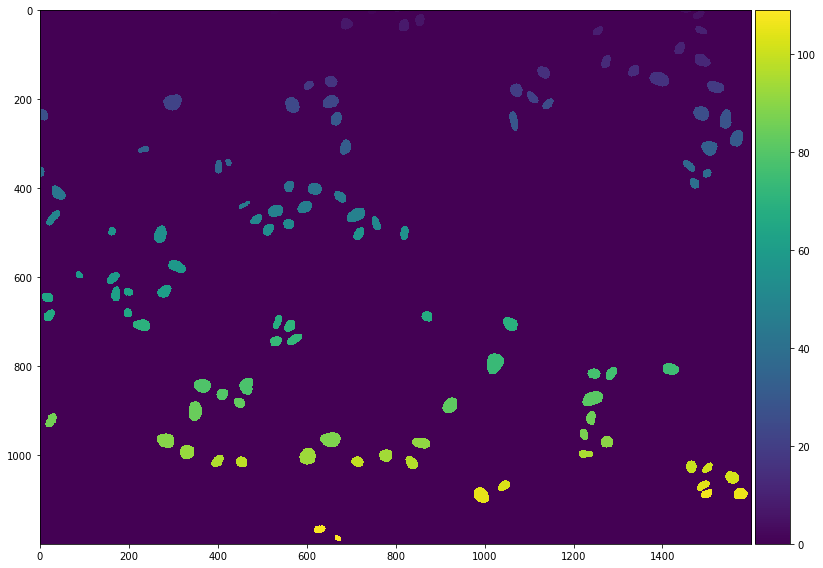

In [79]:
imshow(label(label(image)))

In [72]:
regionprops_table(image)

{'label': array([1, 2]),
 'bbox-0': array([  0, 305]),
 'bbox-1': array([  0, 220]),
 'bbox-2': array([1194,  819]),
 'bbox-3': array([1590, 1043])}

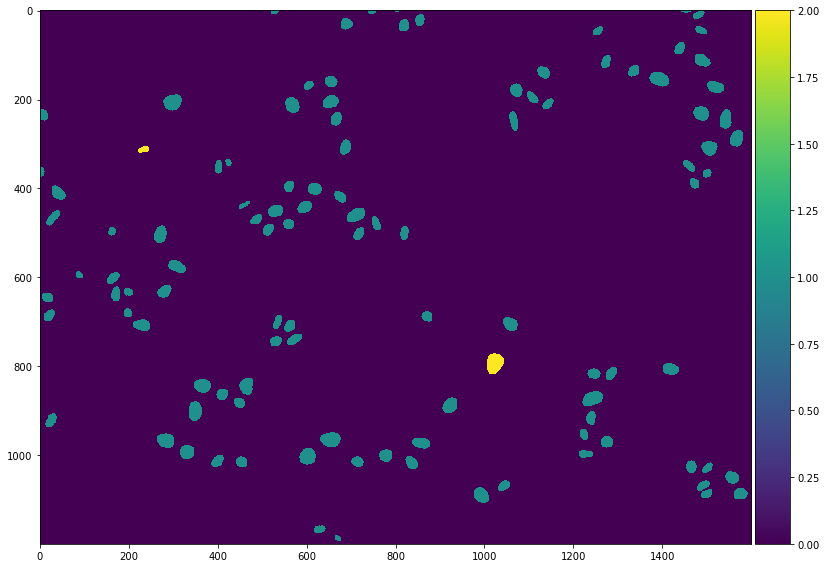

In [80]:
imshow(image)

In [91]:
((image != 0) | (image != 1)).any()

True

In [ ]:
# if more than one segment pixel value is similar 

In [113]:
# max label value in image
np.unique(image).max()

2

In [117]:
np.unique(image, return_counts=True)

(array([0, 1, 2]), array([1854465,   63821,    1714]))

In [118]:
np.unique(label(image), return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109]),
 array([1854465,     152,     143,      57,     123,     365,     463,
            554,     550,     369,     345,     528,     781,     505,
            535,     626,    1148,     569,     355,     804,     700,
            472,    1184,     814,     926,     445,     942,     401,
            942,     652,     607,     903,     648,     922,     307,
            195,     

In [121]:
# number of segments in an image
label(image, return_num=True)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 109)

In [130]:
label(image).max() is not image.max()

True

In [132]:
label(image).max()

109

In [131]:
label(image, return_num=True)[-1]

109

In [170]:
def _is_multiclass(x: np.ndarray) -> bool:
        # check if image is not uniquely labelled 
        # test to see number unique labels is not the same as the max label
        return np.max(label(x)) != np.max(x)

In [171]:
_is_multiclass(label(image))

False

In [172]:
_is_multiclass(image)

True

In [173]:
_is_multiclass(image==1)

True

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


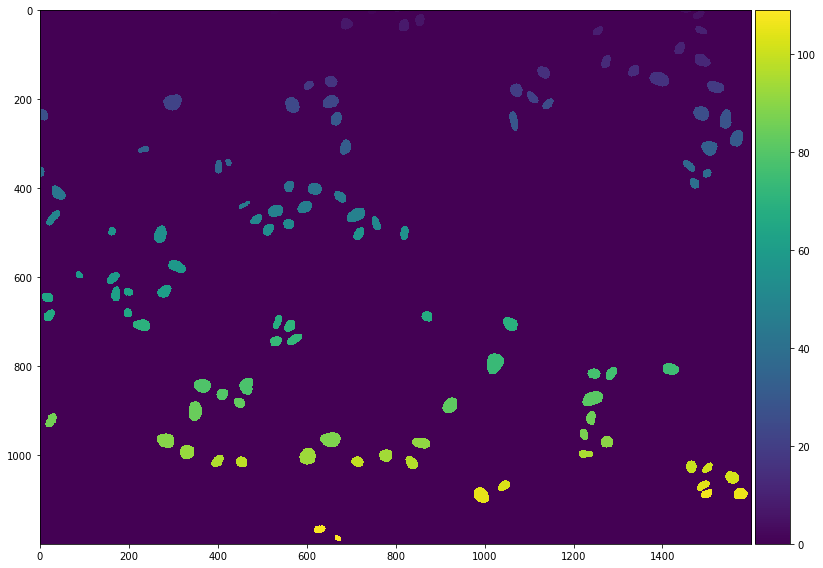

In [138]:
imshow(label(image))

In [139]:
label(label(image)).max()

109

In [141]:
label(image).max()

109

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


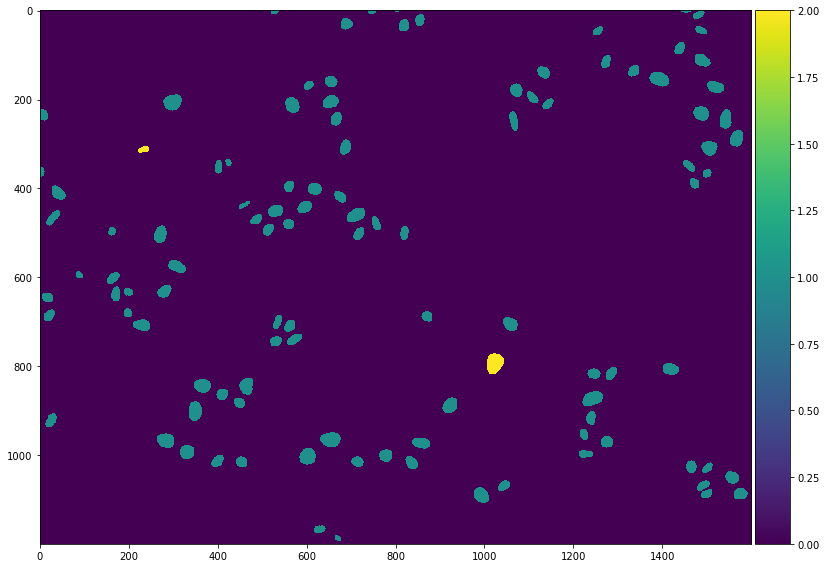

In [154]:
imshow(image)

In [159]:
_is_multiclass(image)

True

In [150]:
unique_image =[0] label(image)

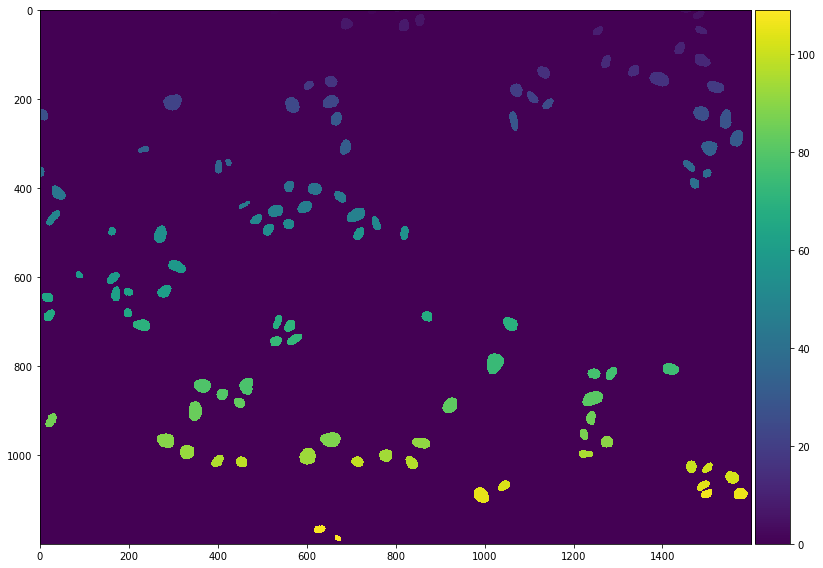

In [156]:
imshow(label(image))

In [151]:
label(unique_image).max(), unique_image.max()

(109, 109)

In [152]:
label(unique_image).max() is not unique_image.max()

True

In [153]:
label(unique_image).max() != unique_image.max()

False

In [165]:
np.unique(image) != label(image)

<ipython-input-165-2e20c816e3ca>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.unique(image) != label(image)


True

In [168]:
len(np.unique(label(image))), np.max(label(image))

(110, 109)

# adding class label to obj properties

In [15]:
labeled = label(image)

In [17]:
regionprops_table(labeled)

{'label': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109]),
 'bbox-0': array([   0,    0,    0,    0,    1,   10,   18,   20,   36,   36,   72,
          98,  101,  123,  126,  139,  148,  159,  159,  165,  183,  189,
         192,  195,  198,  216,  222,  223,  228,  229,  269,  291,  295,
         305,  334,  336,  337,  351,  358,  378,  384,  388,  394,  406,
         429,  429,  438,  444,  450,  458,  463,  469,  482,  484

In [14]:
regionprops_table(image)['label']

array([1, 2])

#### Can also assign measured values from raw image to each segment using `skimage.measure.regionprops` parameters
But also need to load the raw images to be measured first. Cannot currently save out `intensity_image` parameter to object file.

In [ ]:
detailed_objects = btrack.utils.segmentation_to_objects(
    images['mask'], 
    images['gfp'],
    properties = ('area', 'mean_intensity', 'intensity_image'), 
)

In [ ]:
detailed_objects[0]

Example image showing PCNA-iRFP morphology 

In [ ]:
imshow(detailed_objects[0].properties['intensity_image'])

## 2b. Differentiate the objects based on class ID

In [ ]:
objects_gfp = [obj for obj in objects if obj.properties['max_intensity'] == 1]
objects_rfp = [obj for obj in objects if obj.properties['max_intensity'] == 2]

## 3. Classify the objects 

Load model

In [2]:
model = load_model('../models/cellx_classifier_stardist.h5')

Define normalisation functions

In [3]:
def normalize_channels(x):

    for dim in range(x.shape[-1]):
        x[..., dim] = normalize(x[..., dim])
        
    return x

def normalize(x):

    xf = x.astype(np.float32)
    mx = np.mean(xf)
    sd = np.max([np.std(xf), 1./np.prod(x.shape)])

    return (xf - mx) / sd

Define classifier function

In [4]:
def classify_objects(image, objects, obj_type):
    
    # define stages of cell cycle to classify (dependent on model type)
    LABELS = ["interphase", "prometaphase", "metaphase", "anaphase", "apoptosis"]
    
    # iterate over frames
    for n in tqdm(range(image.shape[0])):
        
        # only select objects if in frame
        _objects = [o for o in objects if o.t == n]
        
        # empty placeholder arrays
        crops = []
        to_update = []
        
        # select h2b channel to aid in classification
        fp = gfp if obj_type == 1 else rfp
        
        # create stack by computing each frame of dask array input
        frame = np.stack(
            [image[n, ...].compute(), fp[n, ...].compute()], 
            axis=-1,) 
        
        # create padded image for network
        vol = InfinitePaddedImage(frame, mode = 'reflect')
        
        # iterate over objects 
        for obj in _objects:
            
            # create coords for image slice
            xs = slice(int(obj.x-40), int(obj.x+40), 1)
            ys = slice(int(obj.y-40), int(obj.y+40), 1)
            
            # crop image
            crop = vol[ys, xs, :]
            crop = resize(crop, (64, 64), preserve_range=True).astype(np.float32)
            
            # normalise image
            if crop.shape == (64 ,64, 2):
                crops.append(normalize_channels(crop))
                to_update.append(obj)
            else:
                print(crop.shape)
                
        if not crops:
            continue
            
        # use classifcation model to predict
        pred = model.predict(np.stack(crops, axis=0))
        
        # check correct number of predictions
        assert pred.shape[0] == len(_objects)
        
        # assign labels to objects
        for idx in range(pred.shape[0]):
            obj = _objects[idx]
            
            # assigning details of prediction
            pred_label = np.argmax(pred[idx, ...])
            pred_softmax = softmax(pred[idx, ...])
            logits = {f"prob_{k}": pred_softmax[ki] for ki, k in enumerate(LABELS)}
            
            # write out
            obj.label = pred_label
            obj.properties = logits

    return objects

#### Load raw images for classifier, a colour channel dependent on `obj_type` needed too (i.e. GFP is `obj_type = 1`, RFP is `obj_type = 2`

In [ ]:
bf = images['brightfield']
gfp = images['gfp']
rfp = images['rfp']

#### Classify objects

In [ ]:
objects_gfp = classify_objects(bf, objects_gfp, obj_type = 1)
objects_rfp = classify_objects(bf, objects_rfp, obj_type = 2)

#### Inspect an example object

In [ ]:
objects_gfp[0]

#### Save out classified GFP objects

In [ ]:
with btrack.dataio.HDF5FileHandler(
    f'{root_dir}/{expt}/{pos}/objects_type_1.h5', 'w', obj_type='obj_type_1',
) as hdf:
    #hdf.write_segmentation(masks['mask'])
    hdf.write_objects(objects_gfp)

#### Save out classified RFP objects

In [ ]:
with btrack.dataio.HDF5FileHandler(
    f'{root_dir}/{expt}/{pos}/objects_type_2.h5', 'w', obj_type='obj_type_2',
) as hdf:
    #hdf.write_segmentation(masks['mask'])
    hdf.write_objects(objects_rfp)

# 4. Batch process
Iterate over many experiments and positions (need to ensure you define normalisation and classification functions above first)

In [5]:
root_dir = '/home/nathan/data/kraken/ras'
expt_list = ['ND0010', 'ND0011', 'ND0012']
pos_list = 'all'
overwrite = True

for expt in tqdm(expt_list, position = 0, leave = True):
    
        # Find all positions in that experiment, if pos_list is all then it finds all positions
        if pos_list == 'all':
            pos_list = [pos for pos in os.listdir(f'{root_dir}/{expt}') 
                    if 'Pos' in pos 
                    and os.path.isdir(f'{root_dir}/{expt}/{pos}')]  
            
            
        ### Iterate over all positions in that experiment
        for pos in tqdm(pos_list, position = 0, leave = True):
            
            ### check if overwrite param is false check if raw directory already created and if type of transform file already exists and decide whether to skip pos
            if not overwrite and glob.glob(f'{root_dir}/{expt}/{pos}/*objects*.h5'):
                print(glob.glob(f'{root_dir}/{expt}/{pos}/*objects*.h5'), f'file found, skipping {expt}/{pos}')
                continue
                
            print(f'Starting {expt}/{pos}')
            # load segmentation images and apply necessary transforms and crops
            image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
            transform_path = f'{root_dir}/{expt}/{pos}/gfp_transform_tensor.npy'
            images = DaskOctopusLiteLoader(image_path, 
                               transforms=transform_path,
                               crop=(1200,1600), 
                               remove_background=False)
            
            # ID the objects in each segmentation image and assign option properties to them
            objects = btrack.utils.segmentation_to_objects(
                images['mask'], images['mask'],
                properties = ('area', 'max_intensity', ),
            )
            
            # differentiate the objects based on class ID
            objects_gfp = [obj for obj in objects if obj.properties['max_intensity'] == 1]
            objects_rfp = [obj for obj in objects if obj.properties['max_intensity'] == 2]
            
            # load classifcation model and define labels
            model = load_model('../models/cellx_classifier_stardist.h5')
            LABELS = ["interphase", "prometaphase", "metaphase", "anaphase", "apoptosis"]

            # load images for classifcation
            bf = images['brightfield']
            gfp = images['gfp']
            rfp = images['rfp']
            
            # classify objects
            print("Classifying objects")
            objects_gfp = classify_objects(bf, objects_gfp, obj_type = 1)
            objects_rfp = classify_objects(bf, objects_rfp, obj_type = 2)
            
            # save out classified objects as segmentation h5 file
            with btrack.dataio.HDF5FileHandler(
                f'{root_dir}/{expt}/{pos}/objects_type_1.h5', 'w', obj_type='obj_type_1',
            ) as hdf:
                #hdf.write_segmentation(masks['mask'])
                hdf.write_objects(objects_gfp)
            with btrack.dataio.HDF5FileHandler(
                f'{root_dir}/{expt}/{pos}/objects_type_2.h5', 'w', obj_type='obj_type_2',
            ) as hdf:
                #hdf.write_segmentation(masks['mask'])
                hdf.write_objects(objects_rfp)     

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Starting ND0010/Pos5
Using cropping: (1200, 1600)


[INFO][2022/02/03 08:25:55 PM] Localizing objects from segmentation...
[INFO][2022/02/03 08:25:55 PM] Found intensity_image data
[INFO][2022/02/03 08:25:55 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/03 08:31:04 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/03 08:31:04 PM] ...Found 3579 objects in 1193 frames.


Classifying objects


  0%|          | 0/1193 [00:00<?, ?it/s]

  0%|          | 0/1193 [00:00<?, ?it/s]

[INFO][2022/02/03 08:47:28 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos5/objects_type_1.h5...
[INFO][2022/02/03 08:47:28 PM] Writing objects/obj_type_1
[INFO][2022/02/03 08:47:28 PM] Writing labels/obj_type_1
[INFO][2022/02/03 08:47:28 PM] Loading objects/obj_type_1 (2391, 5) (2391 filtered: None)
[INFO][2022/02/03 08:47:28 PM] Writing properties/obj_type_1/area (2391,)
[INFO][2022/02/03 08:47:28 PM] Writing properties/obj_type_1/max_intensity (2391,)
[INFO][2022/02/03 08:47:28 PM] Writing properties/obj_type_1/prob_interphase (2391,)
[INFO][2022/02/03 08:47:28 PM] Writing properties/obj_type_1/prob_prometaphase (2391,)
[INFO][2022/02/03 08:47:28 PM] Writing properties/obj_type_1/prob_metaphase (2391,)
[INFO][2022/02/03 08:47:28 PM] Writing properties/obj_type_1/prob_anaphase (2391,)
[INFO][2022/02/03 08:47:28 PM] Writing properties/obj_type_1/prob_apoptosis (2391,)
[INFO][2022/02/03 08:47:28 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos5/objects_type_1

Starting ND0010/Pos11
Using cropping: (1200, 1600)


[INFO][2022/02/03 08:47:31 PM] Localizing objects from segmentation...
[INFO][2022/02/03 08:47:31 PM] Found intensity_image data
[INFO][2022/02/03 08:47:31 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/03 08:54:01 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/03 08:54:01 PM] ...Found 2540 objects in 1191 frames.


Classifying objects


  0%|          | 0/1191 [00:00<?, ?it/s]

  0%|          | 0/1191 [00:00<?, ?it/s]

[INFO][2022/02/03 09:09:33 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos11/objects_type_1.h5...
[INFO][2022/02/03 09:09:33 PM] Writing objects/obj_type_1
[INFO][2022/02/03 09:09:33 PM] Writing labels/obj_type_1
[INFO][2022/02/03 09:09:33 PM] Loading objects/obj_type_1 (1351, 5) (1351 filtered: None)
[INFO][2022/02/03 09:09:33 PM] Writing properties/obj_type_1/area (1351,)
[INFO][2022/02/03 09:09:33 PM] Writing properties/obj_type_1/max_intensity (1351,)
[INFO][2022/02/03 09:09:33 PM] Writing properties/obj_type_1/prob_interphase (1351,)
[INFO][2022/02/03 09:09:33 PM] Writing properties/obj_type_1/prob_prometaphase (1351,)
[INFO][2022/02/03 09:09:33 PM] Writing properties/obj_type_1/prob_metaphase (1351,)
[INFO][2022/02/03 09:09:33 PM] Writing properties/obj_type_1/prob_anaphase (1351,)
[INFO][2022/02/03 09:09:33 PM] Writing properties/obj_type_1/prob_apoptosis (1351,)
[INFO][2022/02/03 09:09:33 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos11/objects_type

Starting ND0010/Pos3
Using cropping: (1200, 1600)


[INFO][2022/02/03 09:09:34 PM] Localizing objects from segmentation...
[INFO][2022/02/03 09:09:34 PM] Found intensity_image data
[INFO][2022/02/03 09:09:34 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/03 09:15:45 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/03 09:15:45 PM] ...Found 2367 objects in 1189 frames.


Classifying objects


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/1189 [00:00<?, ?it/s]

[INFO][2022/02/03 09:31:02 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos3/objects_type_1.h5...
[INFO][2022/02/03 09:31:02 PM] Writing objects/obj_type_1
[INFO][2022/02/03 09:31:02 PM] Writing labels/obj_type_1
[INFO][2022/02/03 09:31:02 PM] Loading objects/obj_type_1 (1183, 5) (1183 filtered: None)
[INFO][2022/02/03 09:31:02 PM] Writing properties/obj_type_1/area (1183,)
[INFO][2022/02/03 09:31:02 PM] Writing properties/obj_type_1/max_intensity (1183,)
[INFO][2022/02/03 09:31:02 PM] Writing properties/obj_type_1/prob_interphase (1183,)
[INFO][2022/02/03 09:31:02 PM] Writing properties/obj_type_1/prob_prometaphase (1183,)
[INFO][2022/02/03 09:31:02 PM] Writing properties/obj_type_1/prob_metaphase (1183,)
[INFO][2022/02/03 09:31:02 PM] Writing properties/obj_type_1/prob_anaphase (1183,)
[INFO][2022/02/03 09:31:02 PM] Writing properties/obj_type_1/prob_apoptosis (1183,)
[INFO][2022/02/03 09:31:02 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos3/objects_type_1

Starting ND0010/Pos1
Using cropping: (1200, 1600)


[INFO][2022/02/03 09:31:04 PM] Localizing objects from segmentation...
[INFO][2022/02/03 09:31:04 PM] Found intensity_image data
[INFO][2022/02/03 09:31:04 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/03 09:37:17 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/03 09:37:17 PM] ...Found 2384 objects in 1193 frames.


Classifying objects


  0%|          | 0/1193 [00:00<?, ?it/s]

  0%|          | 0/1193 [00:00<?, ?it/s]

[INFO][2022/02/03 09:54:05 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos1/objects_type_1.h5...
[INFO][2022/02/03 09:54:05 PM] Writing objects/obj_type_1
[INFO][2022/02/03 09:54:05 PM] Writing labels/obj_type_1
[INFO][2022/02/03 09:54:05 PM] Loading objects/obj_type_1 (1192, 5) (1192 filtered: None)
[INFO][2022/02/03 09:54:05 PM] Writing properties/obj_type_1/area (1192,)
[INFO][2022/02/03 09:54:05 PM] Writing properties/obj_type_1/max_intensity (1192,)
[INFO][2022/02/03 09:54:05 PM] Writing properties/obj_type_1/prob_interphase (1192,)
[INFO][2022/02/03 09:54:05 PM] Writing properties/obj_type_1/prob_prometaphase (1192,)
[INFO][2022/02/03 09:54:05 PM] Writing properties/obj_type_1/prob_metaphase (1192,)
[INFO][2022/02/03 09:54:05 PM] Writing properties/obj_type_1/prob_anaphase (1192,)
[INFO][2022/02/03 09:54:05 PM] Writing properties/obj_type_1/prob_apoptosis (1192,)
[INFO][2022/02/03 09:54:05 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos1/objects_type_1

Starting ND0010/Pos8
Using cropping: (1200, 1600)


[INFO][2022/02/03 09:54:06 PM] Localizing objects from segmentation...
[INFO][2022/02/03 09:54:06 PM] Found intensity_image data
[INFO][2022/02/03 09:54:06 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/03 10:01:19 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/03 10:01:20 PM] ...Found 3128 objects in 1193 frames.


Classifying objects


  0%|          | 0/1193 [00:00<?, ?it/s]

  0%|          | 0/1193 [00:00<?, ?it/s]

[INFO][2022/02/03 10:15:41 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos8/objects_type_1.h5...
[INFO][2022/02/03 10:15:41 PM] Writing objects/obj_type_1
[INFO][2022/02/03 10:15:41 PM] Writing labels/obj_type_1
[INFO][2022/02/03 10:15:41 PM] Loading objects/obj_type_1 (1939, 5) (1939 filtered: None)
[INFO][2022/02/03 10:15:41 PM] Writing properties/obj_type_1/area (1939,)
[INFO][2022/02/03 10:15:41 PM] Writing properties/obj_type_1/max_intensity (1939,)
[INFO][2022/02/03 10:15:41 PM] Writing properties/obj_type_1/prob_interphase (1939,)
[INFO][2022/02/03 10:15:41 PM] Writing properties/obj_type_1/prob_prometaphase (1939,)
[INFO][2022/02/03 10:15:41 PM] Writing properties/obj_type_1/prob_metaphase (1939,)
[INFO][2022/02/03 10:15:41 PM] Writing properties/obj_type_1/prob_anaphase (1939,)
[INFO][2022/02/03 10:15:41 PM] Writing properties/obj_type_1/prob_apoptosis (1939,)
[INFO][2022/02/03 10:15:41 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos8/objects_type_1

Starting ND0010/Pos10
Using cropping: (1200, 1600)


[INFO][2022/02/03 10:15:42 PM] Localizing objects from segmentation...
[INFO][2022/02/03 10:15:42 PM] Found intensity_image data
[INFO][2022/02/03 10:15:42 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/03 10:20:32 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/03 10:20:32 PM] ...Found 2850 objects in 1194 frames.


Classifying objects


  0%|          | 0/1194 [00:00<?, ?it/s]

  0%|          | 0/1194 [00:00<?, ?it/s]

[INFO][2022/02/03 10:32:23 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos10/objects_type_1.h5...
[INFO][2022/02/03 10:32:23 PM] Writing objects/obj_type_1
[INFO][2022/02/03 10:32:23 PM] Writing labels/obj_type_1
[INFO][2022/02/03 10:32:23 PM] Loading objects/obj_type_1 (1659, 5) (1659 filtered: None)
[INFO][2022/02/03 10:32:23 PM] Writing properties/obj_type_1/area (1659,)
[INFO][2022/02/03 10:32:23 PM] Writing properties/obj_type_1/max_intensity (1659,)
[INFO][2022/02/03 10:32:23 PM] Writing properties/obj_type_1/prob_interphase (1659,)
[INFO][2022/02/03 10:32:23 PM] Writing properties/obj_type_1/prob_prometaphase (1659,)
[INFO][2022/02/03 10:32:23 PM] Writing properties/obj_type_1/prob_metaphase (1659,)
[INFO][2022/02/03 10:32:23 PM] Writing properties/obj_type_1/prob_anaphase (1659,)
[INFO][2022/02/03 10:32:23 PM] Writing properties/obj_type_1/prob_apoptosis (1659,)
[INFO][2022/02/03 10:32:23 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos10/objects_type

Starting ND0010/Pos0
Using cropping: (1200, 1600)


[INFO][2022/02/03 10:32:25 PM] Localizing objects from segmentation...
[INFO][2022/02/03 10:32:25 PM] Found intensity_image data
[INFO][2022/02/03 10:32:25 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/03 10:37:07 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/03 10:37:07 PM] ...Found 2378 objects in 1190 frames.


Classifying objects


  0%|          | 0/1190 [00:00<?, ?it/s]

  0%|          | 0/1190 [00:00<?, ?it/s]

[INFO][2022/02/03 10:49:04 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos0/objects_type_1.h5...
[INFO][2022/02/03 10:49:04 PM] Writing objects/obj_type_1
[INFO][2022/02/03 10:49:04 PM] Writing labels/obj_type_1
[INFO][2022/02/03 10:49:04 PM] Loading objects/obj_type_1 (1191, 5) (1191 filtered: None)
[INFO][2022/02/03 10:49:04 PM] Writing properties/obj_type_1/area (1191,)
[INFO][2022/02/03 10:49:04 PM] Writing properties/obj_type_1/max_intensity (1191,)
[INFO][2022/02/03 10:49:04 PM] Writing properties/obj_type_1/prob_interphase (1191,)
[INFO][2022/02/03 10:49:04 PM] Writing properties/obj_type_1/prob_prometaphase (1191,)
[INFO][2022/02/03 10:49:04 PM] Writing properties/obj_type_1/prob_metaphase (1191,)
[INFO][2022/02/03 10:49:04 PM] Writing properties/obj_type_1/prob_anaphase (1191,)
[INFO][2022/02/03 10:49:04 PM] Writing properties/obj_type_1/prob_apoptosis (1191,)
[INFO][2022/02/03 10:49:04 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos0/objects_type_1

Starting ND0010/Pos2
Using cropping: (1200, 1600)


[INFO][2022/02/03 10:49:06 PM] Localizing objects from segmentation...
[INFO][2022/02/03 10:49:06 PM] Found intensity_image data
[INFO][2022/02/03 10:49:06 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/03 10:53:46 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/03 10:53:46 PM] ...Found 2374 objects in 1189 frames.


Classifying objects


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/1189 [00:00<?, ?it/s]

[INFO][2022/02/03 11:06:01 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos2/objects_type_1.h5...
[INFO][2022/02/03 11:06:01 PM] Writing objects/obj_type_1
[INFO][2022/02/03 11:06:01 PM] Writing labels/obj_type_1
[INFO][2022/02/03 11:06:01 PM] Loading objects/obj_type_1 (1188, 5) (1188 filtered: None)
[INFO][2022/02/03 11:06:01 PM] Writing properties/obj_type_1/area (1188,)
[INFO][2022/02/03 11:06:01 PM] Writing properties/obj_type_1/max_intensity (1188,)
[INFO][2022/02/03 11:06:01 PM] Writing properties/obj_type_1/prob_interphase (1188,)
[INFO][2022/02/03 11:06:01 PM] Writing properties/obj_type_1/prob_prometaphase (1188,)
[INFO][2022/02/03 11:06:01 PM] Writing properties/obj_type_1/prob_metaphase (1188,)
[INFO][2022/02/03 11:06:01 PM] Writing properties/obj_type_1/prob_anaphase (1188,)
[INFO][2022/02/03 11:06:01 PM] Writing properties/obj_type_1/prob_apoptosis (1188,)
[INFO][2022/02/03 11:06:01 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos2/objects_type_1

Starting ND0010/Pos6
Using cropping: (1200, 1600)


[INFO][2022/02/03 11:06:02 PM] Localizing objects from segmentation...
[INFO][2022/02/03 11:06:02 PM] Found intensity_image data
[INFO][2022/02/03 11:06:02 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/03 11:10:38 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/03 11:10:38 PM] ...Found 2960 objects in 1188 frames.


Classifying objects


  0%|          | 0/1188 [00:00<?, ?it/s]

  0%|          | 0/1188 [00:00<?, ?it/s]

[INFO][2022/02/03 11:22:36 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos6/objects_type_1.h5...
[INFO][2022/02/03 11:22:36 PM] Writing objects/obj_type_1
[INFO][2022/02/03 11:22:36 PM] Writing labels/obj_type_1
[INFO][2022/02/03 11:22:36 PM] Loading objects/obj_type_1 (1776, 5) (1776 filtered: None)
[INFO][2022/02/03 11:22:36 PM] Writing properties/obj_type_1/area (1776,)
[INFO][2022/02/03 11:22:36 PM] Writing properties/obj_type_1/max_intensity (1776,)
[INFO][2022/02/03 11:22:36 PM] Writing properties/obj_type_1/prob_interphase (1776,)
[INFO][2022/02/03 11:22:36 PM] Writing properties/obj_type_1/prob_prometaphase (1776,)
[INFO][2022/02/03 11:22:36 PM] Writing properties/obj_type_1/prob_metaphase (1776,)
[INFO][2022/02/03 11:22:36 PM] Writing properties/obj_type_1/prob_anaphase (1776,)
[INFO][2022/02/03 11:22:36 PM] Writing properties/obj_type_1/prob_apoptosis (1776,)
[INFO][2022/02/03 11:22:36 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos6/objects_type_1

Starting ND0010/Pos7
Using cropping: (1200, 1600)


[INFO][2022/02/03 11:22:38 PM] Localizing objects from segmentation...
[INFO][2022/02/03 11:22:38 PM] Found intensity_image data
[INFO][2022/02/03 11:22:38 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/03 11:27:12 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/03 11:27:12 PM] ...Found 3100 objects in 1195 frames.


Classifying objects


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/1195 [00:00<?, ?it/s]

[INFO][2022/02/03 11:39:29 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos7/objects_type_1.h5...
[INFO][2022/02/03 11:39:29 PM] Writing objects/obj_type_1
[INFO][2022/02/03 11:39:29 PM] Writing labels/obj_type_1
[INFO][2022/02/03 11:39:29 PM] Loading objects/obj_type_1 (1908, 5) (1908 filtered: None)
[INFO][2022/02/03 11:39:29 PM] Writing properties/obj_type_1/area (1908,)
[INFO][2022/02/03 11:39:29 PM] Writing properties/obj_type_1/max_intensity (1908,)
[INFO][2022/02/03 11:39:29 PM] Writing properties/obj_type_1/prob_interphase (1908,)
[INFO][2022/02/03 11:39:29 PM] Writing properties/obj_type_1/prob_prometaphase (1908,)
[INFO][2022/02/03 11:39:29 PM] Writing properties/obj_type_1/prob_metaphase (1908,)
[INFO][2022/02/03 11:39:29 PM] Writing properties/obj_type_1/prob_anaphase (1908,)
[INFO][2022/02/03 11:39:29 PM] Writing properties/obj_type_1/prob_apoptosis (1908,)
[INFO][2022/02/03 11:39:29 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos7/objects_type_1

Starting ND0010/Pos9
Using cropping: (1200, 1600)


[INFO][2022/02/03 11:39:30 PM] Localizing objects from segmentation...
[INFO][2022/02/03 11:39:30 PM] Found intensity_image data
[INFO][2022/02/03 11:39:30 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/03 11:44:16 PM] Objects are of type: <class 'dict'>
[INFO][2022/02/03 11:44:16 PM] ...Found 2682 objects in 1190 frames.


Classifying objects


  0%|          | 0/1190 [00:00<?, ?it/s]

  0%|          | 0/1190 [00:00<?, ?it/s]

[INFO][2022/02/03 11:56:10 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos9/objects_type_1.h5...
[INFO][2022/02/03 11:56:11 PM] Writing objects/obj_type_1
[INFO][2022/02/03 11:56:11 PM] Writing labels/obj_type_1
[INFO][2022/02/03 11:56:11 PM] Loading objects/obj_type_1 (1496, 5) (1496 filtered: None)
[INFO][2022/02/03 11:56:11 PM] Writing properties/obj_type_1/area (1496,)
[INFO][2022/02/03 11:56:11 PM] Writing properties/obj_type_1/max_intensity (1496,)
[INFO][2022/02/03 11:56:11 PM] Writing properties/obj_type_1/prob_interphase (1496,)
[INFO][2022/02/03 11:56:11 PM] Writing properties/obj_type_1/prob_prometaphase (1496,)
[INFO][2022/02/03 11:56:11 PM] Writing properties/obj_type_1/prob_metaphase (1496,)
[INFO][2022/02/03 11:56:11 PM] Writing properties/obj_type_1/prob_anaphase (1496,)
[INFO][2022/02/03 11:56:11 PM] Writing properties/obj_type_1/prob_apoptosis (1496,)
[INFO][2022/02/03 11:56:11 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos9/objects_type_1

Starting ND0010/Pos4
Using cropping: (1200, 1600)


[INFO][2022/02/03 11:56:12 PM] Localizing objects from segmentation...
[INFO][2022/02/03 11:56:12 PM] Found intensity_image data
[INFO][2022/02/03 11:56:12 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 12:00:41 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 12:00:41 AM] ...Found 3611 objects in 1191 frames.


Classifying objects


  0%|          | 0/1191 [00:00<?, ?it/s]

  0%|          | 0/1191 [00:00<?, ?it/s]

[INFO][2022/02/04 12:12:58 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0010/Pos4/objects_type_1.h5...
[INFO][2022/02/04 12:12:58 AM] Writing objects/obj_type_1
[INFO][2022/02/04 12:12:58 AM] Writing labels/obj_type_1
[INFO][2022/02/04 12:12:58 AM] Loading objects/obj_type_1 (2424, 5) (2424 filtered: None)
[INFO][2022/02/04 12:12:58 AM] Writing properties/obj_type_1/area (2424,)
[INFO][2022/02/04 12:12:58 AM] Writing properties/obj_type_1/max_intensity (2424,)
[INFO][2022/02/04 12:12:58 AM] Writing properties/obj_type_1/prob_interphase (2424,)
[INFO][2022/02/04 12:12:58 AM] Writing properties/obj_type_1/prob_prometaphase (2424,)
[INFO][2022/02/04 12:12:58 AM] Writing properties/obj_type_1/prob_metaphase (2424,)
[INFO][2022/02/04 12:12:58 AM] Writing properties/obj_type_1/prob_anaphase (2424,)
[INFO][2022/02/04 12:12:58 AM] Writing properties/obj_type_1/prob_apoptosis (2424,)
[INFO][2022/02/04 12:12:58 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0010/Pos4/objects_type_1

  0%|          | 0/12 [00:00<?, ?it/s]

Starting ND0011/Pos5
Using cropping: (1200, 1600)


[INFO][2022/02/04 12:12:59 AM] Localizing objects from segmentation...
[INFO][2022/02/04 12:12:59 AM] Found intensity_image data
[INFO][2022/02/04 12:12:59 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 12:20:20 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 12:20:20 AM] ...Found 3278 objects in 1639 frames.


Classifying objects


  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

[INFO][2022/02/04 12:38:24 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos5/objects_type_1.h5...
[INFO][2022/02/04 12:38:24 AM] Writing objects/obj_type_1
[INFO][2022/02/04 12:38:24 AM] Writing labels/obj_type_1
[INFO][2022/02/04 12:38:24 AM] Loading objects/obj_type_1 (1639, 5) (1639 filtered: None)
[INFO][2022/02/04 12:38:24 AM] Writing properties/obj_type_1/area (1639,)
[INFO][2022/02/04 12:38:24 AM] Writing properties/obj_type_1/max_intensity (1639,)
[INFO][2022/02/04 12:38:24 AM] Writing properties/obj_type_1/prob_interphase (1639,)
[INFO][2022/02/04 12:38:24 AM] Writing properties/obj_type_1/prob_prometaphase (1639,)
[INFO][2022/02/04 12:38:24 AM] Writing properties/obj_type_1/prob_metaphase (1639,)
[INFO][2022/02/04 12:38:24 AM] Writing properties/obj_type_1/prob_anaphase (1639,)
[INFO][2022/02/04 12:38:24 AM] Writing properties/obj_type_1/prob_apoptosis (1639,)
[INFO][2022/02/04 12:38:24 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos5/objects_type_1

Starting ND0011/Pos11
Using cropping: (1200, 1600)


[INFO][2022/02/04 12:38:26 AM] Localizing objects from segmentation...
[INFO][2022/02/04 12:38:26 AM] Found intensity_image data
[INFO][2022/02/04 12:38:26 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 12:44:42 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 12:44:42 AM] ...Found 2234 objects in 1644 frames.


Classifying objects


  0%|          | 0/1644 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

[INFO][2022/02/04 01:02:18 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos11/objects_type_1.h5...
[INFO][2022/02/04 01:02:18 AM] Writing objects/obj_type_1
[INFO][2022/02/04 01:02:18 AM] Writing labels/obj_type_1
[INFO][2022/02/04 01:02:18 AM] Loading objects/obj_type_1 (2229, 5) (2229 filtered: None)
[INFO][2022/02/04 01:02:18 AM] Writing properties/obj_type_1/area (2229,)
[INFO][2022/02/04 01:02:18 AM] Writing properties/obj_type_1/max_intensity (2229,)
[INFO][2022/02/04 01:02:18 AM] Writing properties/obj_type_1/prob_interphase (2229,)
[INFO][2022/02/04 01:02:18 AM] Writing properties/obj_type_1/prob_prometaphase (2229,)
[INFO][2022/02/04 01:02:18 AM] Writing properties/obj_type_1/prob_metaphase (2229,)
[INFO][2022/02/04 01:02:18 AM] Writing properties/obj_type_1/prob_anaphase (2229,)
[INFO][2022/02/04 01:02:18 AM] Writing properties/obj_type_1/prob_apoptosis (2229,)
[INFO][2022/02/04 01:02:18 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos11/objects_type

Starting ND0011/Pos3
Using cropping: (1200, 1600)


[INFO][2022/02/04 01:02:20 AM] Localizing objects from segmentation...
[INFO][2022/02/04 01:02:20 AM] Found intensity_image data
[INFO][2022/02/04 01:02:20 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 01:09:53 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 01:09:53 AM] ...Found 3276 objects in 1638 frames.


Classifying objects


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/1638 [00:00<?, ?it/s]

[INFO][2022/02/04 01:27:56 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos3/objects_type_1.h5...
[INFO][2022/02/04 01:27:56 AM] Writing objects/obj_type_1
[INFO][2022/02/04 01:27:56 AM] Writing labels/obj_type_1
[INFO][2022/02/04 01:27:56 AM] Loading objects/obj_type_1 (1638, 5) (1638 filtered: None)
[INFO][2022/02/04 01:27:56 AM] Writing properties/obj_type_1/area (1638,)
[INFO][2022/02/04 01:27:56 AM] Writing properties/obj_type_1/max_intensity (1638,)
[INFO][2022/02/04 01:27:56 AM] Writing properties/obj_type_1/prob_interphase (1638,)
[INFO][2022/02/04 01:27:56 AM] Writing properties/obj_type_1/prob_prometaphase (1638,)
[INFO][2022/02/04 01:27:56 AM] Writing properties/obj_type_1/prob_metaphase (1638,)
[INFO][2022/02/04 01:27:56 AM] Writing properties/obj_type_1/prob_anaphase (1638,)
[INFO][2022/02/04 01:27:56 AM] Writing properties/obj_type_1/prob_apoptosis (1638,)
[INFO][2022/02/04 01:27:57 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos3/objects_type_1

Starting ND0011/Pos1
Using cropping: (1200, 1600)


[INFO][2022/02/04 01:27:58 AM] Localizing objects from segmentation...
[INFO][2022/02/04 01:27:58 AM] Found intensity_image data
[INFO][2022/02/04 01:27:58 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 01:34:55 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 01:34:55 AM] ...Found 3142 objects in 1640 frames.


Classifying objects


  0%|          | 0/1640 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

[INFO][2022/02/04 01:58:44 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos1/objects_type_1.h5...
[INFO][2022/02/04 01:58:44 AM] Writing objects/obj_type_1
[INFO][2022/02/04 01:58:44 AM] Writing labels/obj_type_1
[INFO][2022/02/04 01:58:44 AM] Loading objects/obj_type_1 (1573, 5) (1573 filtered: None)
[INFO][2022/02/04 01:58:44 AM] Writing properties/obj_type_1/area (1573,)
[INFO][2022/02/04 01:58:44 AM] Writing properties/obj_type_1/max_intensity (1573,)
[INFO][2022/02/04 01:58:44 AM] Writing properties/obj_type_1/prob_interphase (1573,)
[INFO][2022/02/04 01:58:44 AM] Writing properties/obj_type_1/prob_prometaphase (1573,)
[INFO][2022/02/04 01:58:44 AM] Writing properties/obj_type_1/prob_metaphase (1573,)
[INFO][2022/02/04 01:58:44 AM] Writing properties/obj_type_1/prob_anaphase (1573,)
[INFO][2022/02/04 01:58:44 AM] Writing properties/obj_type_1/prob_apoptosis (1573,)
[INFO][2022/02/04 01:58:44 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos1/objects_type_1

Starting ND0011/Pos8
Using cropping: (1200, 1600)


[INFO][2022/02/04 01:58:47 AM] Localizing objects from segmentation...
[INFO][2022/02/04 01:58:47 AM] Found intensity_image data
[INFO][2022/02/04 01:58:47 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 02:08:32 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 02:08:32 AM] ...Found 2498 objects in 1645 frames.


Classifying objects


  0%|          | 0/1645 [00:00<?, ?it/s]

  0%|          | 0/1645 [00:00<?, ?it/s]

[INFO][2022/02/04 02:31:47 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos8/objects_type_1.h5...
[INFO][2022/02/04 02:31:47 AM] Writing objects/obj_type_1
[INFO][2022/02/04 02:31:47 AM] Writing labels/obj_type_1
[INFO][2022/02/04 02:31:47 AM] Loading objects/obj_type_1 (2494, 5) (2494 filtered: None)
[INFO][2022/02/04 02:31:47 AM] Writing properties/obj_type_1/area (2494,)
[INFO][2022/02/04 02:31:47 AM] Writing properties/obj_type_1/max_intensity (2494,)
[INFO][2022/02/04 02:31:47 AM] Writing properties/obj_type_1/prob_interphase (2494,)
[INFO][2022/02/04 02:31:47 AM] Writing properties/obj_type_1/prob_prometaphase (2494,)
[INFO][2022/02/04 02:31:47 AM] Writing properties/obj_type_1/prob_metaphase (2494,)
[INFO][2022/02/04 02:31:47 AM] Writing properties/obj_type_1/prob_anaphase (2494,)
[INFO][2022/02/04 02:31:47 AM] Writing properties/obj_type_1/prob_apoptosis (2494,)
[INFO][2022/02/04 02:31:47 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos8/objects_type_1

Starting ND0011/Pos10
Using cropping: (1200, 1600)


[INFO][2022/02/04 02:31:51 AM] Localizing objects from segmentation...
[INFO][2022/02/04 02:31:51 AM] Found intensity_image data
[INFO][2022/02/04 02:31:51 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 02:41:55 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 02:41:55 AM] ...Found 1127 objects in 810 frames.


Classifying objects


  0%|          | 0/1640 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

[INFO][2022/02/04 03:06:21 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos10/objects_type_1.h5...
[INFO][2022/02/04 03:06:21 AM] Writing objects/obj_type_1
[INFO][2022/02/04 03:06:21 AM] Writing labels/obj_type_1
[INFO][2022/02/04 03:06:21 AM] Loading objects/obj_type_1 (1123, 5) (1123 filtered: None)
[INFO][2022/02/04 03:06:21 AM] Writing properties/obj_type_1/area (1123,)
[INFO][2022/02/04 03:06:21 AM] Writing properties/obj_type_1/max_intensity (1123,)
[INFO][2022/02/04 03:06:21 AM] Writing properties/obj_type_1/prob_interphase (1123,)
[INFO][2022/02/04 03:06:21 AM] Writing properties/obj_type_1/prob_prometaphase (1123,)
[INFO][2022/02/04 03:06:21 AM] Writing properties/obj_type_1/prob_metaphase (1123,)
[INFO][2022/02/04 03:06:21 AM] Writing properties/obj_type_1/prob_anaphase (1123,)
[INFO][2022/02/04 03:06:21 AM] Writing properties/obj_type_1/prob_apoptosis (1123,)
[INFO][2022/02/04 03:06:21 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos10/objects_type

Starting ND0011/Pos0
Using cropping: (1200, 1600)


[INFO][2022/02/04 03:06:23 AM] Localizing objects from segmentation...
[INFO][2022/02/04 03:06:23 AM] Found intensity_image data
[INFO][2022/02/04 03:06:23 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 03:15:20 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 03:15:20 AM] ...Found 1133 objects in 567 frames.


Classifying objects


  0%|          | 0/1637 [00:00<?, ?it/s]

  0%|          | 0/1637 [00:00<?, ?it/s]

[INFO][2022/02/04 03:39:29 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos0/objects_type_1.h5...
[INFO][2022/02/04 03:39:29 AM] Writing objects/obj_type_1
[INFO][2022/02/04 03:39:29 AM] Writing labels/obj_type_1
[INFO][2022/02/04 03:39:29 AM] Loading objects/obj_type_1 (566, 5) (566 filtered: None)
[INFO][2022/02/04 03:39:29 AM] Writing properties/obj_type_1/area (566,)
[INFO][2022/02/04 03:39:29 AM] Writing properties/obj_type_1/max_intensity (566,)
[INFO][2022/02/04 03:39:29 AM] Writing properties/obj_type_1/prob_interphase (566,)
[INFO][2022/02/04 03:39:29 AM] Writing properties/obj_type_1/prob_prometaphase (566,)
[INFO][2022/02/04 03:39:29 AM] Writing properties/obj_type_1/prob_metaphase (566,)
[INFO][2022/02/04 03:39:29 AM] Writing properties/obj_type_1/prob_anaphase (566,)
[INFO][2022/02/04 03:39:29 AM] Writing properties/obj_type_1/prob_apoptosis (566,)
[INFO][2022/02/04 03:39:29 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos0/objects_type_1.h5
[INFO

Starting ND0011/Pos2
Using cropping: (1200, 1600)


[INFO][2022/02/04 03:39:31 AM] Localizing objects from segmentation...
[INFO][2022/02/04 03:39:31 AM] Found intensity_image data
[INFO][2022/02/04 03:39:31 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 03:48:59 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 03:48:59 AM] ...Found 3272 objects in 1636 frames.


Classifying objects


  0%|          | 0/1636 [00:00<?, ?it/s]

  0%|          | 0/1636 [00:00<?, ?it/s]

[INFO][2022/02/04 04:17:56 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos2/objects_type_1.h5...
[INFO][2022/02/04 04:17:56 AM] Writing objects/obj_type_1
[INFO][2022/02/04 04:17:56 AM] Writing labels/obj_type_1
[INFO][2022/02/04 04:17:56 AM] Loading objects/obj_type_1 (1636, 5) (1636 filtered: None)
[INFO][2022/02/04 04:17:56 AM] Writing properties/obj_type_1/area (1636,)
[INFO][2022/02/04 04:17:56 AM] Writing properties/obj_type_1/max_intensity (1636,)
[INFO][2022/02/04 04:17:56 AM] Writing properties/obj_type_1/prob_interphase (1636,)
[INFO][2022/02/04 04:17:56 AM] Writing properties/obj_type_1/prob_prometaphase (1636,)
[INFO][2022/02/04 04:17:56 AM] Writing properties/obj_type_1/prob_metaphase (1636,)
[INFO][2022/02/04 04:17:56 AM] Writing properties/obj_type_1/prob_anaphase (1636,)
[INFO][2022/02/04 04:17:56 AM] Writing properties/obj_type_1/prob_apoptosis (1636,)
[INFO][2022/02/04 04:17:56 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos2/objects_type_1

Starting ND0011/Pos6
Using cropping: (1200, 1600)


[INFO][2022/02/04 04:17:58 AM] Localizing objects from segmentation...
[INFO][2022/02/04 04:17:58 AM] Found intensity_image data
[INFO][2022/02/04 04:17:58 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 04:28:48 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 04:28:48 AM] ...Found 3276 objects in 1638 frames.


Classifying objects


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/1638 [00:00<?, ?it/s]

[INFO][2022/02/04 04:58:05 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos6/objects_type_1.h5...
[INFO][2022/02/04 04:58:06 AM] Writing objects/obj_type_1
[INFO][2022/02/04 04:58:06 AM] Writing labels/obj_type_1
[INFO][2022/02/04 04:58:06 AM] Loading objects/obj_type_1 (1638, 5) (1638 filtered: None)
[INFO][2022/02/04 04:58:06 AM] Writing properties/obj_type_1/area (1638,)
[INFO][2022/02/04 04:58:06 AM] Writing properties/obj_type_1/max_intensity (1638,)
[INFO][2022/02/04 04:58:06 AM] Writing properties/obj_type_1/prob_interphase (1638,)
[INFO][2022/02/04 04:58:06 AM] Writing properties/obj_type_1/prob_prometaphase (1638,)
[INFO][2022/02/04 04:58:06 AM] Writing properties/obj_type_1/prob_metaphase (1638,)
[INFO][2022/02/04 04:58:06 AM] Writing properties/obj_type_1/prob_anaphase (1638,)
[INFO][2022/02/04 04:58:06 AM] Writing properties/obj_type_1/prob_apoptosis (1638,)
[INFO][2022/02/04 04:58:06 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos6/objects_type_1

Starting ND0011/Pos7
Using cropping: (1200, 1600)


[INFO][2022/02/04 04:58:08 AM] Localizing objects from segmentation...
[INFO][2022/02/04 04:58:08 AM] Found intensity_image data
[INFO][2022/02/04 04:58:08 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 05:09:38 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 05:09:38 AM] ...Found 3292 objects in 1646 frames.


Classifying objects


  0%|          | 0/1646 [00:00<?, ?it/s]

  0%|          | 0/1646 [00:00<?, ?it/s]

[INFO][2022/02/04 05:39:41 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos7/objects_type_1.h5...
[INFO][2022/02/04 05:39:41 AM] Writing objects/obj_type_1
[INFO][2022/02/04 05:39:41 AM] Writing labels/obj_type_1
[INFO][2022/02/04 05:39:41 AM] Loading objects/obj_type_1 (1646, 5) (1646 filtered: None)
[INFO][2022/02/04 05:39:41 AM] Writing properties/obj_type_1/area (1646,)
[INFO][2022/02/04 05:39:41 AM] Writing properties/obj_type_1/max_intensity (1646,)
[INFO][2022/02/04 05:39:41 AM] Writing properties/obj_type_1/prob_interphase (1646,)
[INFO][2022/02/04 05:39:41 AM] Writing properties/obj_type_1/prob_prometaphase (1646,)
[INFO][2022/02/04 05:39:41 AM] Writing properties/obj_type_1/prob_metaphase (1646,)
[INFO][2022/02/04 05:39:41 AM] Writing properties/obj_type_1/prob_anaphase (1646,)
[INFO][2022/02/04 05:39:41 AM] Writing properties/obj_type_1/prob_apoptosis (1646,)
[INFO][2022/02/04 05:39:41 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos7/objects_type_1

Starting ND0011/Pos9
Using cropping: (1200, 1600)


[INFO][2022/02/04 05:39:44 AM] Localizing objects from segmentation...
[INFO][2022/02/04 05:39:44 AM] Found intensity_image data
[INFO][2022/02/04 05:39:44 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 05:50:01 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 05:50:01 AM] ...Found 2308 objects in 1139 frames.


Classifying objects


  0%|          | 0/1646 [00:00<?, ?it/s]

  0%|          | 0/1646 [00:00<?, ?it/s]

[INFO][2022/02/04 06:11:35 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos9/objects_type_1.h5...
[INFO][2022/02/04 06:11:35 AM] Writing objects/obj_type_1
[INFO][2022/02/04 06:11:35 AM] Writing labels/obj_type_1
[INFO][2022/02/04 06:11:35 AM] Loading objects/obj_type_1 (2305, 5) (2305 filtered: None)
[INFO][2022/02/04 06:11:35 AM] Writing properties/obj_type_1/area (2305,)
[INFO][2022/02/04 06:11:35 AM] Writing properties/obj_type_1/max_intensity (2305,)
[INFO][2022/02/04 06:11:35 AM] Writing properties/obj_type_1/prob_interphase (2305,)
[INFO][2022/02/04 06:11:35 AM] Writing properties/obj_type_1/prob_prometaphase (2305,)
[INFO][2022/02/04 06:11:35 AM] Writing properties/obj_type_1/prob_metaphase (2305,)
[INFO][2022/02/04 06:11:35 AM] Writing properties/obj_type_1/prob_anaphase (2305,)
[INFO][2022/02/04 06:11:35 AM] Writing properties/obj_type_1/prob_apoptosis (2305,)
[INFO][2022/02/04 06:11:35 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos9/objects_type_1

Starting ND0011/Pos4
Using cropping: (1200, 1600)


[INFO][2022/02/04 06:11:36 AM] Localizing objects from segmentation...
[INFO][2022/02/04 06:11:36 AM] Found intensity_image data
[INFO][2022/02/04 06:11:36 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 06:20:14 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 06:20:14 AM] ...Found 3280 objects in 1640 frames.


Classifying objects


  0%|          | 0/1640 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

[INFO][2022/02/04 06:41:37 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0011/Pos4/objects_type_1.h5...
[INFO][2022/02/04 06:41:37 AM] Writing objects/obj_type_1
[INFO][2022/02/04 06:41:37 AM] Writing labels/obj_type_1
[INFO][2022/02/04 06:41:37 AM] Loading objects/obj_type_1 (1640, 5) (1640 filtered: None)
[INFO][2022/02/04 06:41:37 AM] Writing properties/obj_type_1/area (1640,)
[INFO][2022/02/04 06:41:37 AM] Writing properties/obj_type_1/max_intensity (1640,)
[INFO][2022/02/04 06:41:37 AM] Writing properties/obj_type_1/prob_interphase (1640,)
[INFO][2022/02/04 06:41:37 AM] Writing properties/obj_type_1/prob_prometaphase (1640,)
[INFO][2022/02/04 06:41:37 AM] Writing properties/obj_type_1/prob_metaphase (1640,)
[INFO][2022/02/04 06:41:37 AM] Writing properties/obj_type_1/prob_anaphase (1640,)
[INFO][2022/02/04 06:41:37 AM] Writing properties/obj_type_1/prob_apoptosis (1640,)
[INFO][2022/02/04 06:41:37 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0011/Pos4/objects_type_1

  0%|          | 0/12 [00:00<?, ?it/s]

Starting ND0012/Pos5
Using cropping: (1200, 1600)


[INFO][2022/02/04 06:41:39 AM] Localizing objects from segmentation...
[INFO][2022/02/04 06:41:39 AM] Found intensity_image data
[INFO][2022/02/04 06:41:39 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 06:50:57 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 06:50:57 AM] ...Found 9566 objects in 1738 frames.


Classifying objects


  0%|          | 0/1738 [00:00<?, ?it/s]

  0%|          | 0/1738 [00:00<?, ?it/s]

[INFO][2022/02/04 07:13:22 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0012/Pos5/objects_type_1.h5...
[INFO][2022/02/04 07:13:22 AM] Writing objects/obj_type_1
[INFO][2022/02/04 07:13:22 AM] Writing labels/obj_type_1
[INFO][2022/02/04 07:13:22 AM] Loading objects/obj_type_1 (7863, 5) (7863 filtered: None)
[INFO][2022/02/04 07:13:22 AM] Writing properties/obj_type_1/area (7863,)
[INFO][2022/02/04 07:13:22 AM] Writing properties/obj_type_1/max_intensity (7863,)
[INFO][2022/02/04 07:13:22 AM] Writing properties/obj_type_1/prob_interphase (7863,)
[INFO][2022/02/04 07:13:22 AM] Writing properties/obj_type_1/prob_prometaphase (7863,)
[INFO][2022/02/04 07:13:22 AM] Writing properties/obj_type_1/prob_metaphase (7863,)
[INFO][2022/02/04 07:13:22 AM] Writing properties/obj_type_1/prob_anaphase (7863,)
[INFO][2022/02/04 07:13:22 AM] Writing properties/obj_type_1/prob_apoptosis (7863,)
[INFO][2022/02/04 07:13:22 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0012/Pos5/objects_type_1

Starting ND0012/Pos11
Using cropping: (1200, 1600)


[INFO][2022/02/04 07:13:24 AM] Localizing objects from segmentation...
[INFO][2022/02/04 07:13:24 AM] Found intensity_image data
[INFO][2022/02/04 07:13:24 AM] Calculating weighted centroids using intensity_image
[INFO][2022/02/04 07:21:20 AM] Objects are of type: <class 'dict'>
[INFO][2022/02/04 07:21:20 AM] ...Found 166 objects in 163 frames.


Classifying objects


  0%|          | 0/1740 [00:00<?, ?it/s]

  0%|          | 0/1740 [00:00<?, ?it/s]

[INFO][2022/02/04 07:38:22 AM] Opening HDF file: /home/nathan/data/kraken/ras/ND0012/Pos11/objects_type_1.h5...
[INFO][2022/02/04 07:38:22 AM] Writing objects/obj_type_1
[INFO][2022/02/04 07:38:23 AM] Writing labels/obj_type_1
[INFO][2022/02/04 07:38:23 AM] Loading objects/obj_type_1 (166, 5) (166 filtered: None)
[INFO][2022/02/04 07:38:23 AM] Writing properties/obj_type_1/area (166,)
[INFO][2022/02/04 07:38:23 AM] Writing properties/obj_type_1/max_intensity (166,)
[INFO][2022/02/04 07:38:23 AM] Writing properties/obj_type_1/prob_interphase (166,)
[INFO][2022/02/04 07:38:23 AM] Writing properties/obj_type_1/prob_prometaphase (166,)
[INFO][2022/02/04 07:38:23 AM] Writing properties/obj_type_1/prob_metaphase (166,)
[INFO][2022/02/04 07:38:23 AM] Writing properties/obj_type_1/prob_anaphase (166,)
[INFO][2022/02/04 07:38:23 AM] Writing properties/obj_type_1/prob_apoptosis (166,)
[INFO][2022/02/04 07:38:23 AM] Closing HDF file: /home/nathan/data/kraken/ras/ND0012/Pos11/objects_type_1.h5
[IN

IndexError: list index out of range